#Reattempt at classification modeling




In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
!pip install pyreadstat
!pip install kneed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.1/620.1 kB 10.9 MB/s eta 0:00:00


#Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
base_path = '/content/drive/My Drive/Group 4'

#which cycle to look at
cycle_folder = 'NHANES 2015-2016 data'

#file name to check metadata for
file_name = 'DEMO_I.xpt'

#Construct full path
full_path = os.path.join(base_path, cycle_folder, file_name)


In [ ]:
#Checking if file path is correct
print(full_path)
print(os.listdir(base_path))
print(os.listdir(os.path.join(base_path, cycle_folder)))

/content/drive/My Drive/Group 4/NHANES 2015-2016 data/DEMO_I.xpt
['NHANES 2013-2014 data', 'NHANES 2015-2016 data', 'NHANES 2017-2018 data', 'Group 4 Project Presentation- July 3rd.gslides', 'Project update-July 10th.gslides', '7 17 25 Group 4 Update.gslides', 'EDA.ipynb', 'EDA results.gdoc', 'Data Dictionary.gsheet', 'Group4 AIcolab Project.ipynb', 'Group 4 Final Project Draft - 7 24 25.gslides', 'Clustering_pipeline_backup.ipynb', 'Classification models reattempt.ipynb']
['DEMO_I.xpt', 'BPX_I.xpt', 'TCHOL_I.xpt', 'HDL_I.xpt', 'PFAS_I.xpt', 'PHTHTE_I.xpt', 'MCQ_I.xpt']


#Extract metadata to try and decide which columns to keep or get rid of for clustering

In [ ]:
#Code to read metadata
import pyreadstat

_, meta = pyreadstat.read_xport(full_path)

print(meta.column_names_to_labels)

{'SEQN': 'Respondent sequence number', 'SDDSRVYR': 'Data release cycle', 'RIDSTATR': 'Interview/Examination status', 'RIAGENDR': 'Gender', 'RIDAGEYR': 'Age in years at screening', 'RIDAGEMN': 'Age in months at screening - 0 to 24 mos', 'RIDRETH1': 'Race/Hispanic origin', 'RIDRETH3': 'Race/Hispanic origin w/ NH Asian', 'RIDEXMON': 'Six month time period', 'RIDEXAGM': 'Age in months at exam - 0 to 19 years', 'DMQMILIZ': 'Served active duty in US Armed Forces', 'DMQADFC': 'Served in a foreign country', 'DMDBORN4': 'Country of birth', 'DMDCITZN': 'Citizenship status', 'DMDYRSUS': 'Length of time in US', 'DMDEDUC3': 'Education level - Children/Youth 6-19', 'DMDEDUC2': 'Education level - Adults 20+', 'DMDMARTL': 'Marital status', 'RIDEXPRG': 'Pregnancy status at exam', 'SIALANG': 'Language of SP Interview', 'SIAPROXY': 'Proxy used in SP Interview?', 'SIAINTRP': 'Interpreter used in SP Interview?', 'FIALANG': 'Language of Family Interview', 'FIAPROXY': 'Proxy used in Family Interview?', 'FIAI

# Remove the redundant features by identifying Key Biomarkers in each xpt file

In [ ]:
#PFAS biomarkers
pfas_features = [
    'LBXPFDE','LBXPFHS','LBXMPAH','LBXPFNA','LBXPFUA','LBXPFDO','LBXNFOA','LBXBFOA','LBXNFOS','LBXMFOS'
]

#PHTHTE biomarkers
phthalate_features = ['URXCNP', 'URXCOP', 'URXECP', 'URXHIBP', 'URXMBP',
    'URXMC1', 'URXMCOH', 'URXMEP', 'URXMHBP', 'URXMHH',
    'URXMHNC', 'URXMHP', 'URXMIB', 'URXMNP', 'URXMOH', 'URXMZP']

#HDL biomarkers
hdl_features = ['LBDHDD']

#TCHOL biomarkers
tchol_features = ['LBXTC']

#BPX biomarkers
bpx_features = [
    'BPXPTY',   # Regular(1) or irregular
    'BPXCHR',   # Heart rate (60 sec)
    'BPXSY1',   # Systolic BP (1st reading)
    'BPXDI1',   # Diastolic BP (1st reading)
    'BPXSY2',   # Systolic BP (2nd reading)
    'BPXDI2',   # Diastolic BP (2nd reading)
    'BPXSY3',   # Systolic BP (3rd reading)
    'BPXDI3',   # Diastolic BP (3rd reading)
    'BPXSY4',   # Systolic BP (4th reading)
    'BPXDI4'    # Diastolic BP (4th reading)
]

mcq_heart_features = [
    'MCQ160A',  #Arthritis
    'MCQ160B',  # Congestive heart failure
    'MCQ160C',  # Doctor ever told you had coronary heart disease - Added this back
    'MCQ160D',  # Angina
    'MCQ160E',  # Heart attack
    'MCQ160F',  # Stroke
    'MCQ160K',  # Chronic Bronchitis
    'MCQ160N',  # Gout
    'MCQ160O',  # COPD
    'MCQ300A',  # Family history of heart attack
]

demographic_features = [
    'RIAGENDR',  # Gender
    'RIDAGEYR',  # Age
    'RIDRETH3',  # Race/ethnicity
    'DMDBORN4', #Country of birth
    'DMDEDUC2', #Educational level
    'DMDMARTL', #Marital status
    'DMDHHSIZ', #Household size
    'DMDHHSZE', #Adults 60+ in household
    'DMDHRGND', #Gender of household reference person
    'INDFMPIR' #Ratio of family income to poverty
]

# Load and merge data from group folder

In [ ]:
cycles = ['NHANES 2013-2014 data', 'NHANES 2015-2016 data', 'NHANES 2017-2018 data']

# Feature lists from previous steps
pfas_features = [
    'LBXPFDE','LBXPFHS','LBXMPAH','LBXPFNA','LBXPFUA','LBXPFDO','LBXNFOA','LBXBFOA','LBXNFOS','LBXMFOS'
]

phthalate_features = [
    'URXCNP', 'URXCOP', 'URXECP', 'URXHIBP', 'URXMBP',
    'URXMC1', 'URXMCOH', 'URXMEP', 'URXMHBP', 'URXMHH',
    'URXMHNC', 'URXMHP', 'URXMIB', 'URXMNP', 'URXMOH', 'URXMZP'
]

hdl_features = ['LBDHDD']

tchol_features = ['LBXTC']

bpx_features = [
    'BPXPTY',   # Regular(1) or irregular
    'BPXCHR',   # Heart rate (60 sec)
    'BPXSY1',   # Systolic BP (1st reading)
    'BPXDI1',   # Diastolic BP (1st reading)
    'BPXSY2',   # Systolic BP (2nd reading)
    'BPXDI2',   # Diastolic BP (2nd reading)
    'BPXSY3',   # Systolic BP (3rd reading)
    'BPXDI3',   # Diastolic BP (3rd reading)
    'BPXSY4',   # Systolic BP (4th reading)
    'BPXDI4'    # Diastolic BP (4th reading)
]

mcq_heart_features = [
    'MCQ160A',  #Arthritis
    'MCQ160B',  # Congestive heart failure
    'MCQ160C',  # Doctor ever told you had coronary heart disease - Added this back
    'MCQ160D',  # Angina
    'MCQ160E',  # Heart attack
    'MCQ160F',  # Stroke
    'MCQ160K',  # Chronic Bronchitis
    'MCQ160N',  # Gout
    'MCQ160O',  # COPD
    'MCQ300A',  # Family history of heart attack
]

demographic_features = [
    'RIAGENDR',  # Gender
    'RIDAGEYR',  # Age
    'RIDRETH3',  # Race/ethnicity
    'DMDBORN4', #Country of birth
    'DMDEDUC2', #Educational level
    'DMDMARTL', #Marital status
    'DMDHHSIZ', #Household size
    'DMDHHSZE', #Adults 60+ in household
    'DMDHRGND', #Gender of household reference person
    'INDFMPIR' #Ratio of family income to poverty
]

# Map files with correct suffix letters and lowercase extensions
file_map = {
    'NHANES 2013-2014 data': {
        'PFAS': 'PFAS_H.xpt',
        'PHTHTE': 'PHTHTE_H.xpt',
        'HDL': 'HDL_H.xpt',
        'TCHOL': 'TCHOL_H.xpt',
        'BPX': 'BPX_H.xpt',
        'MCQ': 'MCQ_H.xpt',
        'DEMO': 'DEMO_H.xpt',
    },
    'NHANES 2015-2016 data': {
        'PFAS': 'PFAS_I.xpt',
        'PHTHTE': 'PHTHTE_I.xpt',
        'HDL': 'HDL_I.xpt',
        'TCHOL': 'TCHOL_I.xpt',
        'BPX': 'BPX_I.xpt',
        'MCQ': 'MCQ_I.xpt',
        'DEMO': 'DEMO_I.xpt',
    },
    'NHANES 2017-2018 data': {
        'PFAS': 'PFAS_J.xpt',
        'PHTHTE': 'PHTHTE_J.xpt',
        'HDL': 'HDL_J.xpt',
        'TCHOL': 'TCHOL_J.xpt',
        'BPX': 'BPX_J.xpt',
        'MCQ': 'MCQ_J.xpt',
        'DEMO': 'DEMO_J.xpt',
    }
}


# Mapping file type to feature list
feature_lookup = {
    'PFAS': pfas_features,
    'PHTHTE': phthalate_features,
    'HDL': hdl_features,
    'TCHOL': tchol_features,
    'BPX': bpx_features,
    'MCQ': mcq_heart_features,
    'DEMO': demographic_features
}

# Begin loading
dfs = []

for cycle in cycles:
    dfs_cycle = []
    files_for_cycle = file_map[cycle]

    for file_key, file_name in files_for_cycle.items():
        full_path = os.path.join(base_path, cycle, file_name)
        print(f'Loading {full_path} ...')
        try:
            df, meta = pyreadstat.read_xport(full_path)
        except Exception as e:
            print(f'Error reading {file_name}: {e}')
            continue

        feature_list = feature_lookup[file_key]
        available_features = ['SEQN'] + [f for f in feature_list if f in df.columns]
        df_sub = df[available_features]
        dfs_cycle.append(df_sub)

    if dfs_cycle:
        merged_cycle = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='inner'), dfs_cycle)
        merged_cycle['cycle'] = cycle
        dfs.append(merged_cycle)

# Combine all cycleshi
combined_df = pd.concat(dfs, ignore_index=True)

# Optional: final feature list + 'SEQN' + 'cycle' to order columns
final_features = ['SEQN'] + pfas_features + phthalate_features + hdl_features + tchol_features + bpx_features + mcq_heart_features + demographic_features + ['cycle']
final_features = [col for col in final_features if col in combined_df.columns]  # drop ones not in data
combined_df = combined_df[final_features]

print('Merged data shape:', combined_df.shape)
combined_df.head()

Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/PFAS_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/PHTHTE_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/HDL_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/TCHOL_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/BPX_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/MCQ_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2013-2014 data/DEMO_H.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2015-2016 data/PFAS_I.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2015-2016 data/PHTHTE_I.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2015-2016 data/HDL_I.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2015-2016 data/TCHOL_I.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2015-2016 data/BPX_I.xpt ...
Loading /content/drive/My Drive/Group 4/NHANES 2015-2016 data/MCQ_I.xpt ...

,SEQN,LBXPFDE,LBXPFHS,LBXMPAH,LBXPFNA,LBXPFUA,LBXPFDO,LBXNFOA,LBXBFOA,LBXNFOS,...,RIDAGEYR,RIDRETH3,DMDBORN4,DMDEDUC2,DMDMARTL,DMDHHSIZ,DMDHHSZE,DMDHRGND,INDFMPIR,cycle
0,73568.0,0.2,3.0,0.20,0.5,0.10,0.07,NaN,NaN,NaN,...,26.0,3.0,1.0,5.0,5.0,3.0,0.0,2.0,5.00,NHANES 2013-2014 data
1,73571.0,0.3,2.0,0.20,1.3,0.07,0.07,NaN,NaN,NaN,...,76.0,3.0,1.0,5.0,1.0,2.0,2.0,1.0,5.00,NHANES 2013-2014 data
2,73574.0,0.1,0.2,0.07,0.7,0.07,0.07,NaN,NaN,NaN,...,33.0,6.0,2.0,5.0,1.0,4.0,0.0,2.0,2.10,NHANES 2013-2014 data
3,73576.0,0.2,7.6,0.07,0.6,0.07,0.10,NaN,NaN,NaN,...,16.0,4.0,1.0,NaN,NaN,6.0,0.0,2.0,1.58,NHANES 2013-2014 data
4,73577.0,0.1,1.2,0.07,0.4,0.07,0.07,NaN,NaN,NaN,...,32.0,1.0,2.0,1.0,6.0,7.0,0.0,2.0,0.29,NHANES 2013-2014 data


In [ ]:
random_seed = 42

In [ ]:
classification_df = combined_df.copy(deep = True)

# Split the data

In [ ]:
# Step 1: Filter out the unwanted cycle
classification_df = classification_df[classification_df['cycle'] != 'NHANES 2013-2014 data']

print(classification_df.shape)



(4303, 60)


In [ ]:
#Before splitting the data we need to make sure our target has no null values because stratify feature in train_test_split

#Check number of nulls for variable
classification_df['MCQ160C'].isna().sum()

np.int64(787)

In [ ]:
#Check value counts
print(classification_df['MCQ160C'].value_counts())

#Drop nan and 9.0 in 'MCQ160C'
classification_df = classification_df[
    (classification_df['MCQ160C'].notna()) &
    (classification_df['MCQ160C'] != 9.0)
]

# Optional: check result
print(classification_df['MCQ160C'].value_counts())

MCQ160C
2.0    3356
1.0     150
9.0      10
Name: count, dtype: int64
MCQ160C
2.0    3356
1.0     150
Name: count, dtype: int64


In [ ]:
#Check null values
print(classification_df['MCQ160C'].isna().sum())

0


In [ ]:
from sklearn.model_selection import train_test_split

#Make a copy of the original dataframe to have as a backup
copy_of_classification_df = classification_df.copy(deep = True)

# Split the data into training and testing sets
df_train, df_test = train_test_split(classification_df, train_size = 0.6, random_state = random_seed, stratify = classification_df['MCQ160C'])

df_val, df_test = train_test_split(df_test, train_size = 0.5, random_state = random_seed, stratify = df_test['MCQ160C'])

df_train, df_val, df_test = df_train.reset_index(drop = True), df_val.reset_index(drop = True), df_test.reset_index(drop = True)


In [ ]:
#Check shapes after splits
print(df_train.shape)

print(df_test.shape)

print(df_val.shape)

(2103, 60)
(702, 60)
(701, 60)


#Check if there are uncommon columns in the train,test,val splits

In [ ]:
def common_cols(df1, df2, df3):
  common = []
  for col in df1.columns:
    if col in df2.columns and col in df3.columns:
      common.append(col)
  return common

#Check to see if the number of common columns matches the number of columns in each of the splits found before
common = common_cols(df_train, df_test, df_val)
print(len(common))


60


#Removing identifiers

In [ ]:
#Create a function to find identifiers by checking if the number of unique values in a column is equal to a
def find_identifiers (df1):
  identifiers = []
  for col in df1.columns:
    if df1[col].nunique() == len(df1):
      identifiers.append(col)
  return identifiers

print(find_identifiers(df_train))
print(find_identifiers(df_val))
print(find_identifiers(df_test))

['SEQN']
['SEQN']
['SEQN']


In [ ]:
#Drop our identifier
df_train = df_train.drop(columns = ['SEQN'])
df_val = df_val.drop(columns = ['SEQN'])
df_test = df_test.drop(columns = ['SEQN'])

In [ ]:
#Check if dropping worked (should have 59 features now)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2103, 59)
(701, 59)
(702, 59)


#Handle date time variables

In [ ]:
#Check if we have a cycle feature in the columns
'cycle' in classification_df.columns

True

In [ ]:
#Check the nature of the outputs for the feature
classification_df['cycle'].value_counts()

,count
cycle,
NHANES 2017-2018 data,1761
NHANES 2015-2016 data,1745


In [ ]:
df_train = df_train.drop(columns = ['cycle'])
df_val = df_val.drop(columns = ['cycle'])
df_test = df_test.drop(columns = ['cycle'])

In [ ]:
#Check shape of all three (Should have 58 features now)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2103, 58)
(701, 58)
(702, 58)


# Cleaning and processing missing data

In [ ]:
df_step6 = pd.concat([df_train, df_val, df_test], sort = False)

df_step6.shape

(3506, 58)

In [ ]:
#Check the number of missing values and percentage of missing values compared to full
missing_summary = df_step6.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_summary / len(df_step6)) * 100
missing_report = pd.DataFrame({'Missing Count': missing_summary, 'Missing %': missing_percent})
print(missing_report[missing_report['Missing Count'] > 0])

          Missing Count   Missing %
BPXCHR             3506  100.000000
BPXDI4             3277   93.468340
BPXSY4             3277   93.468340
LBXPFDO            1871   53.365659
INDFMPIR            419   11.950941
BPXDI1              317    9.041643
BPXSY1              317    9.041643
LBXMPAH             258    7.358813
LBXPFHS             258    7.358813
LBXPFDE             258    7.358813
LBXNFOA             258    7.358813
LBXBFOA             258    7.358813
LBXPFNA             258    7.358813
LBXPFUA             258    7.358813
LBXNFOS             258    7.358813
LBXMFOS             258    7.358813
BPXDI3              201    5.733029
LBXTC               201    5.733029
LBDHDD              201    5.733029
BPXSY3              201    5.733029
BPXSY2              193    5.504849
BPXDI2              193    5.504849
BPXPTY              133    3.793497
URXCNP              123    3.508272
URXECP              123    3.508272
URXCOP              123    3.508272
URXMZP              123    3

In [ ]:
print(combined_df.groupby('cycle')['LBXBFOA'].apply(lambda x: x.isnull().mean()))
print(combined_df.groupby('cycle')['LBXNFOS'].apply(lambda x: x.isnull().mean()))
print(combined_df.groupby('cycle')['LBXNFOA'].apply(lambda x: x.isnull().mean()))
print(combined_df.groupby('cycle')['LBXMFOS'].apply(lambda x: x.isnull().mean()))

cycle
NHANES 2013-2014 data    1.000000
NHANES 2015-2016 data    0.081567
NHANES 2017-2018 data    0.095640
Name: LBXBFOA, dtype: float64
cycle
NHANES 2013-2014 data    1.000000
NHANES 2015-2016 data    0.081567
NHANES 2017-2018 data    0.095640
Name: LBXNFOS, dtype: float64
cycle
NHANES 2013-2014 data    1.000000
NHANES 2015-2016 data    0.081567
NHANES 2017-2018 data    0.095640
Name: LBXNFOA, dtype: float64
cycle
NHANES 2013-2014 data    1.000000
NHANES 2015-2016 data    0.081567
NHANES 2017-2018 data    0.095640
Name: LBXMFOS, dtype: float64


In [ ]:
#Some columns with overly high missingness can be removed
df_train = df_train.drop(columns = ['BPXCHR', 'BPXSY4', 'BPXDI4', 'LBXPFDO'])
df_test = df_test.drop(columns = ['BPXCHR', 'BPXSY4', 'BPXDI4', 'LBXPFDO'])
df_val = df_val.drop(columns = ['BPXCHR', 'BPXSY4', 'BPXDI4', 'LBXPFDO'])

In [ ]:
#Check shape of each split
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2103, 54)
(702, 54)
(701, 54)


## Imputation

In [ ]:
#For imputation we need to handle both categorical and numerical features

## Use unique value count instead of dtype to detect categorical vars
def cat_var_checker_by_uniques(df, threshold=20):
    return pd.DataFrame([
        [col, df[col].nunique(dropna=False)]
        for col in df.columns
        if df[col].nunique(dropna=False) <= threshold
    ], columns=['var', 'nunique']).sort_values(by='nunique', ascending=False)

# Get categorical columns (e.g. less than or equal to 20 unique values)
cat_vars_df = cat_var_checker_by_uniques(df_train, threshold=20)
categorical_cols = cat_vars_df['var'].tolist()

# Define numeric columns as the rest
numeric_cols = [col for col in df_train.columns if col not in categorical_cols]

In [ ]:
print(categorical_cols)
print(len(categorical_cols))

print(numeric_cols)
print(len(numeric_cols))

['LBXBFOA', 'DMDEDUC2', 'DMDHHSIZ', 'DMDMARTL', 'RIDRETH3', 'MCQ300A', 'DMDHHSZE', 'BPXPTY', 'MCQ160B', 'MCQ160A', 'MCQ160F', 'MCQ160D', 'MCQ160E', 'MCQ160O', 'MCQ160K', 'MCQ160N', 'DMDBORN4', 'MCQ160C', 'RIAGENDR', 'DMDHRGND']
20
['LBXPFDE', 'LBXPFHS', 'LBXMPAH', 'LBXPFNA', 'LBXPFUA', 'LBXNFOA', 'LBXNFOS', 'LBXMFOS', 'URXCNP', 'URXCOP', 'URXECP', 'URXHIBP', 'URXMBP', 'URXMC1', 'URXMCOH', 'URXMEP', 'URXMHBP', 'URXMHH', 'URXMHNC', 'URXMHP', 'URXMIB', 'URXMNP', 'URXMOH', 'URXMZP', 'LBDHDD', 'LBXTC', 'BPXSY1', 'BPXDI1', 'BPXSY2', 'BPXDI2', 'BPXSY3', 'BPXDI3', 'RIDAGEYR', 'INDFMPIR']
34


In [ ]:
#Check skew for imputation

skewness = df_train[numeric_cols].skew().sort_values()
# Normally distributed = skew between -1 and 1
mean_impute_cols = skewness[(-1 <= skewness) & (skewness <= 1)].index.tolist()
median_impute_cols = skewness[(skewness < -1) | (skewness > 1)].index.tolist()

In [ ]:
print(mean_impute_cols)
print(median_impute_cols)

['BPXDI3', 'BPXDI1', 'BPXDI2', 'RIDAGEYR', 'INDFMPIR', 'BPXSY2', 'BPXSY1', 'BPXSY3', 'LBXTC']
['LBDHDD', 'LBXMFOS', 'LBXPFNA', 'LBXPFHS', 'LBXNFOS', 'URXMOH', 'URXMHH', 'LBXPFDE', 'LBXPFUA', 'LBXMPAH', 'URXHIBP', 'URXMIB', 'URXMHP', 'URXCOP', 'URXMZP', 'URXECP', 'LBXNFOA', 'URXMEP', 'URXCNP', 'URXMBP', 'URXMCOH', 'URXMHBP', 'URXMHNC', 'URXMC1', 'URXMNP']


In [ ]:
from sklearn.impute import SimpleImputer

# Mean imputation
mean_imputer = SimpleImputer(strategy='mean')
df_train[mean_impute_cols] = mean_imputer.fit_transform(df_train[mean_impute_cols])
df_val[mean_impute_cols] = mean_imputer.transform(df_val[mean_impute_cols])
df_test[mean_impute_cols] = mean_imputer.transform(df_test[mean_impute_cols])

# Median imputation
median_imputer = SimpleImputer(strategy='median')
df_train[median_impute_cols] = median_imputer.fit_transform(df_train[median_impute_cols])
df_val[median_impute_cols] = median_imputer.transform(df_val[median_impute_cols])
df_test[median_impute_cols] = median_imputer.transform(df_test[median_impute_cols])

In [ ]:
#Categorical imputation
mode_imputer = SimpleImputer(strategy='most_frequent')
df_train[categorical_cols] = mode_imputer.fit_transform(df_train[categorical_cols])
df_val[categorical_cols] = mode_imputer.transform(df_val[categorical_cols])
df_test[categorical_cols] = mode_imputer.transform(df_test[categorical_cols])

In [ ]:
#Check if imputation worked
print("Nulls in train:", df_train.isnull().sum().sum())
print("Nulls in val:", df_val.isnull().sum().sum())
print("Nulls in test:", df_test.isnull().sum().sum())

Nulls in train: 0
Nulls in val: 0
Nulls in test: 0


#Encoding

In [ ]:
#Exclude target for encoding separately
categorical_cols = [col for col in categorical_cols if col != 'MCQ160C']

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Count unique values for each categorical variable
cat_unique_counts = df_train[categorical_cols].nunique().sort_values(ascending=False)
print(cat_unique_counts.tolist())
print(cat_unique_counts.sum())

[8, 7, 7, 7, 6, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2]
76


In [ ]:
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col].astype(str))
    df_val[col] = le.transform(df_val[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))
    label_encoders[col] = le

In [ ]:
target_le = LabelEncoder()

df_train['MCQ160C'] = target_le.fit_transform(df_train['MCQ160C'])
df_val['MCQ160C'] = target_le.transform(df_val['MCQ160C'])
df_test['MCQ160C'] = target_le.transform(df_test['MCQ160C'])

In [ ]:
print(df_train['MCQ160C'].value_counts())
print(df_val['MCQ160C'].value_counts())

MCQ160C
1    2013
0      90
Name: count, dtype: int64
MCQ160C
1    671
0     30
Name: count, dtype: int64


In [ ]:
df_train.shape

(2103, 54)

#Spliting target and features

In [ ]:
#Explicit target
target = 'MCQ160C'

#Feature matrix
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])

#Target vector
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

#Scaling the data

In [ ]:
#We can use min-max normalization or standard scaler depending on outliers in the data
outlier_counts = {}

for col in numeric_cols:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = X_train[(X_train[col] < lower_bound) | (X_train[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

# Show sorted outlier counts
sorted_outliers = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)
for col, count in sorted_outliers:
    print(f"{col}: {count} outliers")


URXMNP: 374 outliers
URXMCOH: 278 outliers
URXMEP: 267 outliers
URXCOP: 250 outliers
URXMHNC: 240 outliers
LBXMPAH: 222 outliers
URXMZP: 211 outliers
LBXPFUA: 196 outliers
URXMC1: 190 outliers
URXMOH: 185 outliers
URXMHP: 179 outliers
URXCNP: 178 outliers
URXMHH: 176 outliers
LBXPFNA: 175 outliers
URXMBP: 173 outliers
URXMHBP: 172 outliers
URXMIB: 170 outliers
LBXNFOS: 168 outliers
URXHIBP: 168 outliers
URXECP: 165 outliers
LBXPFDE: 148 outliers
LBXMFOS: 145 outliers
LBXPFHS: 140 outliers
LBXNFOA: 133 outliers
BPXSY1: 77 outliers
BPXSY2: 67 outliers
BPXDI3: 60 outliers
BPXSY3: 58 outliers
LBDHDD: 55 outliers
BPXDI1: 54 outliers
BPXDI2: 54 outliers
LBXTC: 48 outliers
RIDAGEYR: 0 outliers
INDFMPIR: 0 outliers


Lots of outliers for some features so we'll use Standard scaler

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

#Handling class imbalance

In [ ]:
pd.Series(y_train).value_counts()

,count
1,2013
0,90


In [ ]:
#from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
#ADASYN sampling technique

#from imblearn.over_sampling import ADASYN
#sampler = ADASYN(random_state=42)
#X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_scaled, y_train)

In [ ]:

from imblearn.combine import SMOTEENN

#Apply SMOTEENN
sampler = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_scaled, y_train)

In [ ]:
#SMOTETomek technique
#from imblearn.combine import SMOTETomek

#sampler = SMOTETomek(random_state=42)
#X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_scaled, y_train)


In [ ]:
pd.Series(y_train_resampled).value_counts()

,count
0,2013
1,1637


#Set up ML and parameter grids

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

random_seed = 42

models = {
    'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_seed),
    'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed),
    'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
    'hgbc': HistGradientBoostingClassifier(random_state=random_seed)
}

# Set up pipelines
pipes = {acronym: Pipeline([('model', model)]) for acronym, model in models.items()}

# Parameter grids
param_grids = {}

param_grids['xgb'] = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.3],
    #'model__subsample': [0.8, 1.0],
    #'model__colsample_bytree': [0.8, 1.0]
}

param_grids['mlpc'] = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__solver': ['adam', 'sgd'],
    'model__alpha': [0.0001, 0.001],
    'model__learning_rate': ['constant', 'adaptive']
}

param_grids['rfc'] = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__bootstrap': [True, False]
}

param_grids['hgbc'] = {
    'model__learning_rate': [0.01, 0.1],
    'model__max_iter': [100, 200],
    'model__max_depth': [3, 5],
    'model__min_samples_leaf': [20, 30]
}

#Model training and evaluation

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report



grid_searches = {}
model_predictions = {}

for acronym, pipe in pipes.items():
    print(f"\nTraining model: {acronym.upper()}")

    # Models without class_weight need SMOTE
    if acronym in ['xgb', 'mlpc', 'hgbc']:
        sampler = SMOTEENN(random_state=42)
        X_fit, y_fit = sampler.fit_resample(X_train_scaled, y_train)
    else:  # Models with class_weight (like RFC)
        X_fit, y_fit = X_train_scaled, y_train

    grid_search = GridSearchCV(pipe, param_grid=param_grids[acronym],
                               cv=5, n_jobs=-1, scoring='f1_macro', verbose=1)
    grid_search.fit(X_fit, y_fit)

    grid_searches[acronym] = grid_search

    print(f"Best Parameters for {acronym}: {grid_search.best_params_}")
    print(f"Best CV f1_macro Score: {grid_search.best_score_:.4f}")

    y_pred = grid_search.best_estimator_.predict(X_test_scaled)
    model_predictions[acronym] = y_pred

    print(f"Prediction shape: {y_pred.shape} | True labels shape: {y_test.shape}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))


Training model: XGB
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:36:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters for xgb: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
Best CV f1_macro Score: 0.9906
Prediction shape: (702,) | True labels shape: (702,)
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.43      0.67      0.52        30
     Class 1       0.98      0.96      0.97       672

    accuracy                           0.95       702
   macro avg       0.71      0.81      0.75       702
weighted avg       0.96      0.95      0.95       702


Training model: MLPC
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters for mlpc: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (50, 50), 'model__learning_rate': 'constant', 'model__solver': 'adam'}
Best CV f1_macro Score: 0.9895
Prediction shape: (702,) | True labels shape: (702,)
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.27      0.63 

#PR Curve

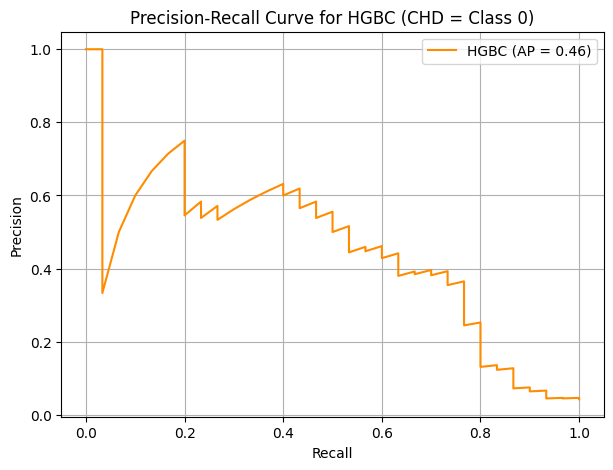

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# HGBC
hgbc_probs = hgbc_model.predict_proba(X_test)[:, 0]  # Probability of class 0
precision_hgbc, recall_hgbc, _ = precision_recall_curve(y_test, hgbc_probs, pos_label=0)
ap_hgbc = average_precision_score(y_test, hgbc_probs, pos_label=0)

plt.figure(figsize=(7, 5))
plt.plot(recall_hgbc, precision_hgbc, label=f'HGBC (AP = {ap_hgbc:.2f})', color='darkorange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for HGBC (CHD = Class 0)")
plt.legend()
plt.grid(True)
plt.show()

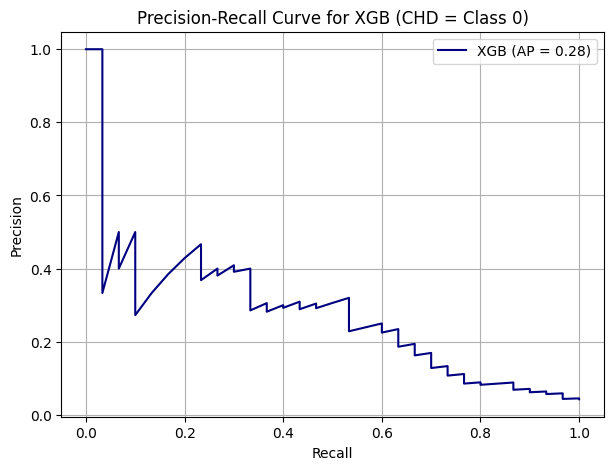

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# XGB
xgb_probs = xgb_model.predict_proba(X_test)[:, 0]  # Probability of class 0
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_probs, pos_label=0)
ap_xgb = average_precision_score(y_test, xgb_probs, pos_label=0)

plt.figure(figsize=(7, 5))
plt.plot(recall_xgb, precision_xgb, label=f'XGB (AP = {ap_xgb:.2f})', color='navy')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for XGB (CHD = Class 0)")
plt.legend()
plt.grid(True)
plt.show()


#Feature importance

/tmp/ipython-input-79-2278195803.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importance.head(10), x="Importance", y="Feature", palette="viridis")


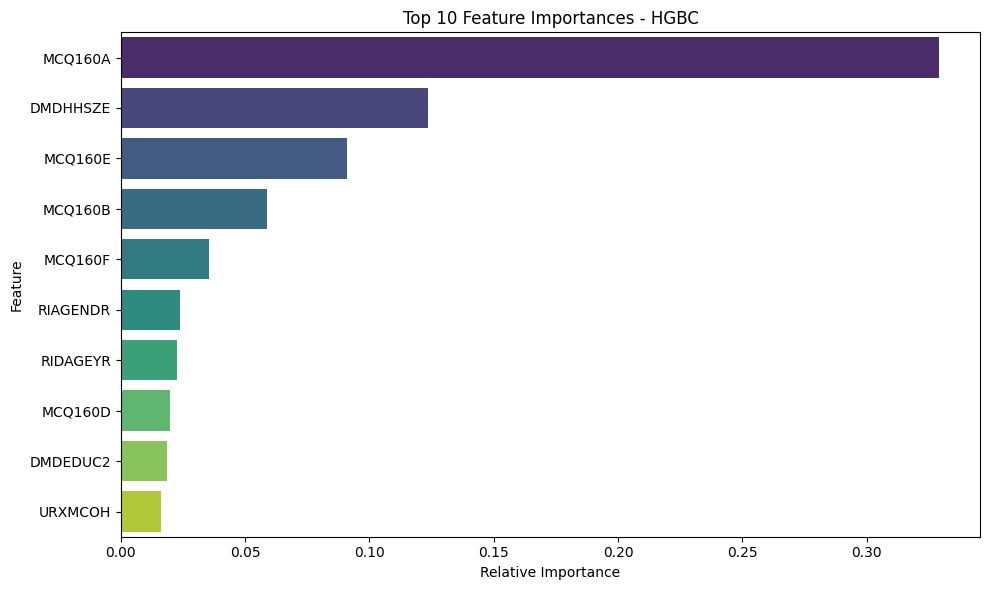

In [ ]:
'''XGB feature importance'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get trained HGBC model
xgb_model = grid_searches["xgb"].best_estimator_
importances = xgb_model.named_steps["model"].feature_importances_

# Match with feature names
feature_names = X_train.columns
feat_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importance.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Feature Importances - HGBC")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
print(feat_importance.head(10))

     Feature  Importance
34   MCQ160A    0.329157
50  DMDHHSZE    0.123731
37   MCQ160E    0.091158
35   MCQ160B    0.058714
38   MCQ160F    0.035607
43  RIAGENDR    0.023774
44  RIDAGEYR    0.022570
36   MCQ160D    0.019904
47  DMDEDUC2    0.018744
15   URXMCOH    0.016145


/tmp/ipython-input-73-1978938805.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_importance_df.head(10), x="Importance", y="Feature", palette="viridis")


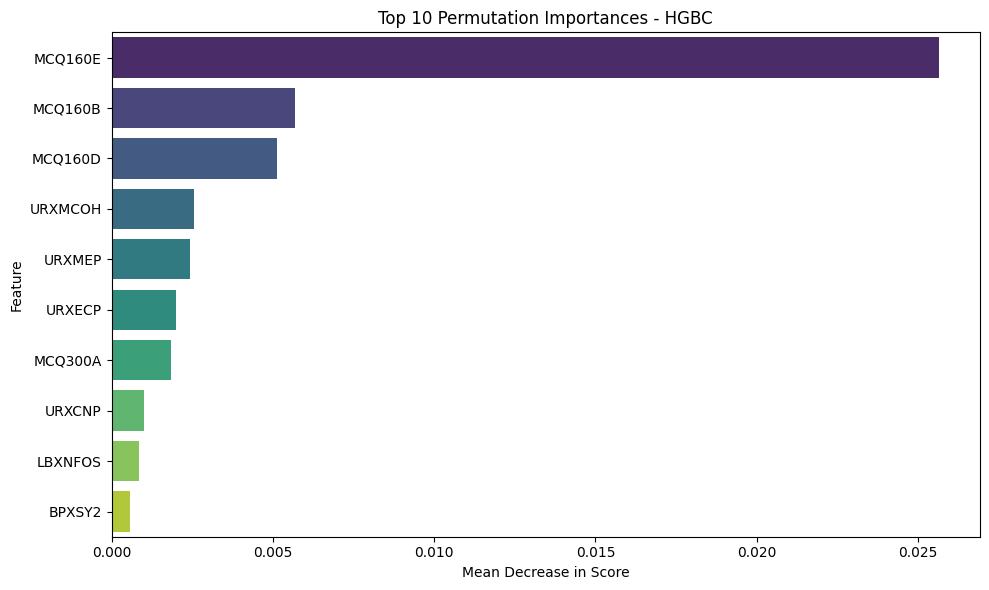

In [ ]:
from sklearn.inspection import permutation_importance

# Get the best HGBC model from the grid search
hgbc_model = grid_searches["hgbc"].best_estimator_

# Calculate permutation importance
result = permutation_importance(
    hgbc_model, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Organize results into a DataFrame
perm_importance_df = pd.DataFrame({
    "Feature": X_test_scaled.columns,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(data=perm_importance_df.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Permutation Importances - HGBC")
plt.xlabel("Mean Decrease in Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
print(perm_importance_df.head(10))

    Feature  Importance
37  MCQ160E    0.025641
35  MCQ160B    0.005698
36  MCQ160D    0.005128
15  URXMCOH    0.002564
16   URXMEP    0.002422
11   URXECP    0.001994
42  MCQ300A    0.001852
9    URXCNP    0.000997
7   LBXNFOS    0.000855
30   BPXSY2    0.000570


In [1]:
!pip freeze> requirements.txt